## Importing libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator, load_img

## Importing the dataset

In [13]:
train_dir = 'dataset/fer2013/train/'
test_dir = 'dataset/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

In [14]:
train_count

,angry,disgust,fear,happy,neutral,sad,surprise
train,3995,436,4097,7215,4965,4830,3171


In [15]:
test_count

,angry,disgust,fear,happy,neutral,sad,surprise
test,958,111,1024,1774,1233,1247,831


## Plot number of images in dataset

In [16]:
df = pd.DataFrame()
df = pd.concat([df, train_count, test_count])
train_number, test_number = df.transpose().sum()[0], df.transpose().sum()[1]

fig = px.bar(
    df.transpose(),
    title='Training (' + str(train_number) + ') and Test (' + str(test_number) + ') count')
fig.show()

## Sample images

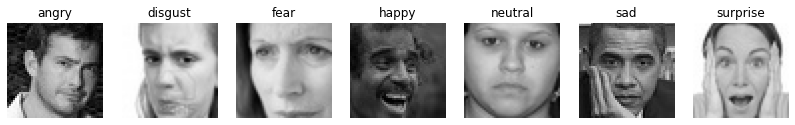

In [17]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(row,col),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(row,col),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Defining Model

In [20]:
def get_model(input_size=(48, 48, 1), n_classes=7):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    opt = Adam(lr=0.0001, decay=10e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [21]:
model_ccn = get_model((row,col,1), classes)
model_ccn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 128)      

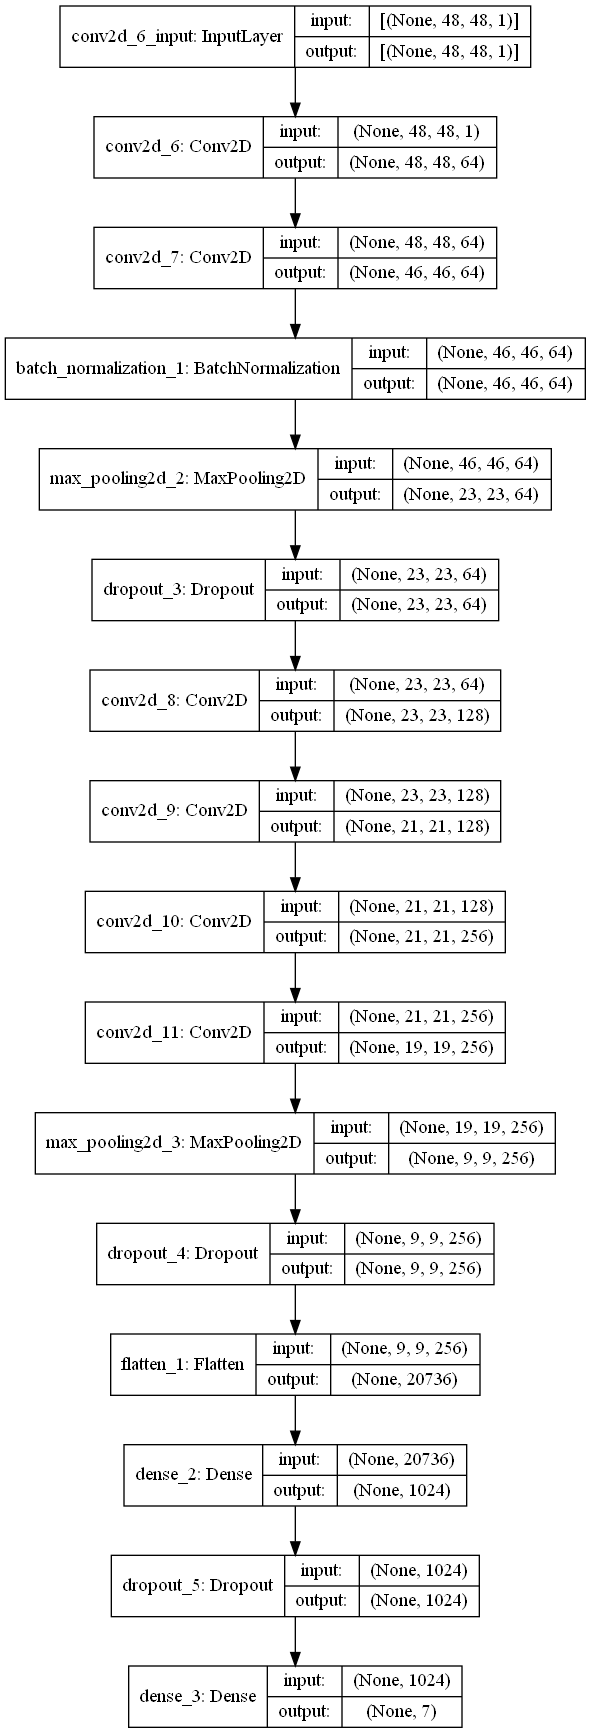

In [22]:
plot_model(model_ccn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)


## Training Model

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model_ccn.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
  9/448 [..............................] - ETA: 25:11 - loss: 3.8663 - accuracy: 0.1781  

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = model_ccn.evaluate(training_set)
test_loss, test_accu = model_ccn.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))